In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
tf.random.set_seed(42)
%load_ext tensorboard

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train, x_valid, y_valid = x_train[:-5000], y_train[:-5000], x_train[-5000:], y_train[-5000:]

In [2]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
x_train_pca = pca.fit_transform(x_train.reshape(-1, 3072))
x_valid_pca = pca.transform(x_valid.reshape(-1, 3072))

In [3]:
x_valid_pca.shape

(5000, 657)

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
for i in range(20):
    model.add(tf.keras.layers.Dense(100, activation = "swish", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))

In [5]:
from pathlib import Path
from time import strftime

def get_logdir():
    return Path("logs_test") / strftime("run_%Y_%m_%d_%H_%M_%S")

logdir = get_logdir()

In [6]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, profile_batch = (100, 300))

k = tf.keras.backend

class GrowingLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(k.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        k.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

lr_growth = GrowingLearningRate(factor = 1.005)


In [7]:
optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

In [8]:
history = model.fit(x_train_pca, y_train, epochs = 1, validation_data = (x_valid_pca, y_valid), 
                   callbacks = [early_stop_cb, lr_growth])

1407/1407 [==============================] - 7s 2ms/step - loss: 91.2595 - accuracy: 0.1144 - val_loss: 2.5291 - val_accuracy: 0.1024


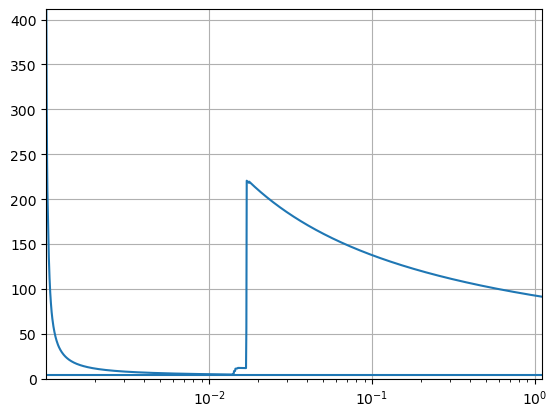

In [9]:
plt.plot(lr_growth.rates, lr_growth.losses)
plt.gca().set_xscale("log")
plt.hlines(min(lr_growth.losses), min(lr_growth.rates), max(lr_growth.rates))
plt.axis([min(lr_growth.rates), max(lr_growth.rates), 0, lr_growth.losses[0]])
plt.grid()

In [10]:
lr_growth.rates[np.argmin(lr_growth.losses)]

0.01378312

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
for i in range(20):
    model.add(tf.keras.layers.Dense(100, activation = "swish", kernel_initializer = "he_normal"))
model.add(tf.keras.layers.Dense(10, activation = "softmax"))
optimizer = tf.keras.optimizers.Nadam(learning_rate = 5e-4, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

In [12]:
history = model.fit(x_train_pca, y_train, epochs = 100, validation_data = (x_valid_pca, y_valid), 
                   callbacks = [early_stop_cb, tensorboard_cb])

Epoch 1/100
1407/1407 [==============================] - 7s 2ms/step - loss: 2.8973 - accuracy: 0.1724 - val_loss: 2.0454 - val_accuracy: 0.2612
Epoch 2/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.9638 - accuracy: 0.2740 - val_loss: 1.8718 - val_accuracy: 0.3122
Epoch 3/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.8023 - accuracy: 0.3295 - val_loss: 1.7790 - val_accuracy: 0.3506
Epoch 4/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.6877 - accuracy: 0.3768 - val_loss: 1.7261 - val_accuracy: 0.3724
Epoch 5/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.5782 - accuracy: 0.4268 - val_loss: 1.6260 - val_accuracy: 0.4228
Epoch 6/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.4832 - accuracy: 0.4652 - val_loss: 1.5755 - val_accuracy: 0.4426
Epoch 7/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.3952 - accuracy: 0.4990 - val_loss: 1.5887 - val_ac

In [13]:
tf.keras.backend.clear_session()

In [14]:
model_with_batch = tf.keras.Sequential()
model_with_batch.add(tf.keras.layers.Flatten())
for i in range(20):
    model_with_batch.add(tf.keras.layers.Dense(100, kernel_initializer = "he_normal", use_bias = False))
    model_with_batch.add(tf.keras.layers.BatchNormalization())
    model_with_batch.add(tf.keras.layers.Activation("swish"))
model_with_batch.add(tf.keras.layers.Dense(10, activation = "softmax"))

In [15]:
optimizer = tf.keras.optimizers.Nadam(learning_rate = 5e-4, beta_1 = 0.9, beta_2 = 0.999)
model_with_batch.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

In [16]:
history = model_with_batch.fit(x_train_pca, y_train, epochs = 100, validation_data = (x_valid_pca, y_valid), callbacks = [early_stop_cb, tensorboard_cb])

Epoch 1/100
1407/1407 [==============================] - 13s 4ms/step - loss: 2.1246 - accuracy: 0.2129 - val_loss: 1.9512 - val_accuracy: 0.3070
Epoch 2/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.8278 - accuracy: 0.3327 - val_loss: 1.6996 - val_accuracy: 0.3718
Epoch 3/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.6861 - accuracy: 0.3924 - val_loss: 1.5957 - val_accuracy: 0.4304
Epoch 4/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.5904 - accuracy: 0.4296 - val_loss: 1.5346 - val_accuracy: 0.4520
Epoch 5/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.4979 - accuracy: 0.4678 - val_loss: 1.4613 - val_accuracy: 0.4816
Epoch 6/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.4311 - accuracy: 0.4921 - val_loss: 1.4471 - val_accuracy: 0.4864
Epoch 7/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.3678 - accuracy: 0.5106 - val_loss: 1.4409 - val_a

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_pca_scaled = scaler.fit_transform(x_train_pca)
x_valid_pca_scaled = scaler.transform(x_valid_pca)
x_test_pca_scaled = scaler.transform(pca.transform(x_test.reshape(-1, 3072)))

In [18]:
model_with_SELU = tf.keras.Sequential()
model_with_SELU.add(tf.keras.layers.Flatten())
for i in range(20):
    model_with_SELU.add(tf.keras.layers.Dense(100, kernel_initializer = "lecun_normal", activation = "selu"))

model_with_SELU.add(tf.keras.layers.Dense(10, activation = "softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate = 5e-4)
model_with_SELU.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

early_stop_cb = tf.keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cifar10_selu", save_best_only = True)
run_index = 1
logdir = Path() / "logs_test" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir)
callbacks = [early_stop_cb, model_checkpoint_cb, tensorboard_cb]

In [19]:
model_with_SELU.fit(x_train_pca_scaled, y_train, epochs = 100, validation_data = (x_valid_pca_scaled, y_valid), callbacks = callbacks)

Epoch 1/100
1398/1407 [============================>.] - ETA: 0s - loss: 2.1827 - accuracy: 0.1845

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 8s 4ms/step - loss: 2.1811 - accuracy: 0.1852 - val_loss: 1.9987 - val_accuracy: 0.2562
Epoch 2/100
1402/1407 [============================>.] - ETA: 0s - loss: 1.8865 - accuracy: 0.2993

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 5s 3ms/step - loss: 1.8867 - accuracy: 0.2994 - val_loss: 1.8637 - val_accuracy: 0.3284
Epoch 3/100
1395/1407 [============================>.] - ETA: 0s - loss: 1.7613 - accuracy: 0.3588

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 4s 3ms/step - loss: 1.7608 - accuracy: 0.3590 - val_loss: 1.8049 - val_accuracy: 0.3580
Epoch 4/100
1403/1407 [============================>.] - ETA: 0s - loss: 1.6648 - accuracy: 0.3985

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 5s 3ms/step - loss: 1.6648 - accuracy: 0.3986 - val_loss: 1.7211 - val_accuracy: 0.3804
Epoch 5/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.5700 - accuracy: 0.4377 - val_loss: 1.7372 - val_accuracy: 0.3956
Epoch 6/100
1384/1407 [============================>.] - ETA: 0s - loss: 1.4888 - accuracy: 0.4690

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 5s 3ms/step - loss: 1.4894 - accuracy: 0.4687 - val_loss: 1.6725 - val_accuracy: 0.4224
Epoch 7/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.4125 - accuracy: 0.4952 - val_loss: 1.6748 - val_accuracy: 0.4088
Epoch 8/100
1395/1407 [============================>.] - ETA: 0s - loss: 1.3404 - accuracy: 0.5230

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 4s 3ms/step - loss: 1.3414 - accuracy: 0.5228 - val_loss: 1.6321 - val_accuracy: 0.4300
Epoch 9/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.2766 - accuracy: 0.5455 - val_loss: 1.7242 - val_accuracy: 0.4284
Epoch 10/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.2123 - accuracy: 0.5732 - val_loss: 1.7191 - val_accuracy: 0.4324
Epoch 11/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.1508 - accuracy: 0.5935 - val_loss: 1.7470 - val_accuracy: 0.4332
Epoch 12/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.1013 - accuracy: 0.6145 - val_loss: 1.7329 - val_accuracy: 0.4348
Epoch 13/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0483 - accuracy: 0.6313 - val_loss: 1.7881 - val_accuracy: 0.4392
Epoch 14/100
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0024 - accuracy: 0.6515 - val_loss: 1.8139 - val_accuracy:

In [20]:
model_drop_SELU = tf.keras.Sequential()
model_drop_SELU.add(tf.keras.layers.Flatten())
for i in range(20):
    model_drop_SELU.add(tf.keras.layers.Dense(100, kernel_initializer = "lecun_normal", activation = "selu"))

model_drop_SELU.add(tf.keras.layers.AlphaDropout(rate = 0.4))
model_drop_SELU.add(tf.keras.layers.Dense(10, activation = "softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate = 5e-4)
model_drop_SELU.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

early_stop_cb = tf.keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cifar10_selu", save_best_only = True)
run_index = 1
logdir = Path() / "logs_test" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir)
callbacks = [early_stop_cb, model_checkpoint_cb, tensorboard_cb]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 3072))
x_valid_scaled = scaler.transform(x_valid.reshape(-1, 3072))
x_test_scaled =  scaler.transform(x_test.reshape(-1, 3072))

In [21]:
model_drop_SELU.fit(x_train_scaled, y_train, epochs = 100, validation_data = (x_valid_scaled, y_valid), callbacks = callbacks)

Epoch 1/100
1396/1407 [============================>.] - ETA: 0s - loss: 1.9407 - accuracy: 0.3073

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 10s 5ms/step - loss: 1.9391 - accuracy: 0.3078 - val_loss: 2.0301 - val_accuracy: 0.3668
Epoch 2/100
1398/1407 [============================>.] - ETA: 0s - loss: 1.7334 - accuracy: 0.3855

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 7s 5ms/step - loss: 1.7333 - accuracy: 0.3859 - val_loss: 1.8368 - val_accuracy: 0.4166
Epoch 3/100
1397/1407 [============================>.] - ETA: 0s - loss: 1.6309 - accuracy: 0.4295

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 7s 5ms/step - loss: 1.6309 - accuracy: 0.4295 - val_loss: 1.8036 - val_accuracy: 0.4480
Epoch 4/100
1400/1407 [============================>.] - ETA: 0s - loss: 1.5636 - accuracy: 0.4539

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 7s 5ms/step - loss: 1.5636 - accuracy: 0.4539 - val_loss: 1.7515 - val_accuracy: 0.4504
Epoch 5/100
1398/1407 [============================>.] - ETA: 0s - loss: 1.5063 - accuracy: 0.4750

INFO:tensorflow:Assets written to: cifar10_selu\assets


INFO:tensorflow:Assets written to: cifar10_selu\assets


1407/1407 [==============================] - 7s 5ms/step - loss: 1.5067 - accuracy: 0.4748 - val_loss: 1.6718 - val_accuracy: 0.4682
Epoch 6/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.4584 - accuracy: 0.4919 - val_loss: 1.7719 - val_accuracy: 0.4708
Epoch 7/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.4176 - accuracy: 0.5102 - val_loss: 1.7461 - val_accuracy: 0.4880
Epoch 8/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.3778 - accuracy: 0.5228 - val_loss: 1.7256 - val_accuracy: 0.4770
Epoch 9/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.3438 - accuracy: 0.5364 - val_loss: 1.9097 - val_accuracy: 0.4824
Epoch 10/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.3096 - accuracy: 0.5473 - val_loss: 1.9849 - val_accuracy: 0.4860
Epoch 11/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.2785 - accuracy: 0.5604 - val_loss: 1.9769 - val_accuracy: 0.

In [22]:
%tensorboard --logdir=./logs_test

Reusing TensorBoard on port 6006 (pid 8996), started 0:50:31 ago. (Use '!kill 8996' to kill it.)